# Stackjack continued: Monte-Carlo

In Task 4 of Project 1 we implemented a (naive) Monte-Carlo simulation to evaluate the starting state of the Stackjack environment
under different strategies.

In this notebook we expand on this idea by implementing different algorithms that allow (efficient)
evaluation of all states and also policy improvement.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
from stackjackClass import StackJack

GAMMA = 1
N_ACTIONS = 3
actionNames = ['Stand', 'S1', 'S2']

policyStand = [[1, 0, 0] for s in StackJack.STATES]
policyStack1 = [[0, 1, 0] for s in StackJack.STATES]
policyRandom = [[0.3, 0.5, 0.2] for s in StackJack.STATES]

policies = [policyStand, policyStack1, policyRandom]
policyNames = ['Stand', 'Stack1', 'Random']

## 1. Monte Carlo prediction

Below we implement (first-visit) MC prediction, see also page 92 in Sutton & Barto.

In [3]:
# Initialize:
# V(s) <- arbitrarily
# Returns(s) <- empty list

# Loop forever (for each episode):
    # Generate an episode following pi: S0, A0, R1, S1, A1, R2, ..., ST-1, AT-1, RT
    # G <- 0
    # Loop for each step of episode, t = T-1, T-2, ..., 0:
        # G <- GAMMA * G + Rt+1
        # Unless the pair St, At appears in S0, A0, S1, A1, ..., St-1, At-1:
            # Append G to Returns(St)
            # V(St) <- average(Returns(St))

In [4]:
# Make one move according to policy
def sampleAction(policy, state):
    actionProbabilities = policy[state]
    allActions = list(range(len(actionProbabilities)))
    action = np.random.choice(allActions, p = actionProbabilities)
    return action

# Play one game according to policy
def playOneGame(sj: StackJack, policy):
    sj.reset()
    states = [sj.state]
    action = sampleAction(policy, sj.state)
    actions = [action]
    rewards = [0]
    while sj.state != sj.BUST:
        reward, state = sj.step(action)
        action = sampleAction(policy, sj.state)
        rewards.append(reward)
        states.append(sj.state)
        actions.append(action)
        
    return states, actions, rewards

In [5]:
def monteCarloEval(sj: StackJack, policy, n):
    # Warning, this does not work (!):
    # returns = [[]] * sj.BUST

    returns = [[] for _ in range(sj.BUST)]
    
    for i in range(n):
        states, actions, rewards = playOneGame(sj, policy)
        G = 0
        T = len(rewards) - 1
        for t in reversed(range(T)):
            G = GAMMA * G + rewards[t + 1]
            if not (t>0 and states[t] in states[0:t-1]):
                returns[states[t]].append(G)
    
    values = [np.mean(rets) for rets in returns]
    
    return values

Results:

c:\Users\Hentsche\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Hentsche\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


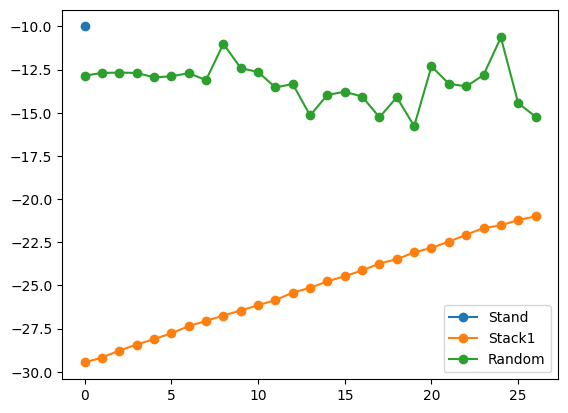

In [6]:
plt.figure()

n = 1000
sj = StackJack()

for policy, name in zip(policies, policyNames):
    values = monteCarloEval(sj, policy, n)
    plt.plot(values[0:sj.BUST], 'o-', label = name)

plt.legend()
plt.show()


Obersvations:
- Looks good for Stack1
- Looks ok for Random, higher variance for later states (visited less often)
- Does not work for non-initial states for Stand

## 2. Monte-Carlo prediction with exploring starts

By choosing the starting state randomly, giving every state a non-zero proability, we ensure that all states are visited.

In [7]:
# Play one game according to policy
# (Starting in state s0)
# (Being able to choose the starting state is kind of cheating!)
def playOneGameES(sj: StackJack, policy, s0=0):
    sj.reset(s0)
    states = [sj.state]
    action = sampleAction(policy, sj.state)
    actions = [action]
    rewards = [0]
    while sj.state != sj.BUST:
        reward, state = sj.step(action)
        action = sampleAction(policy, sj.state)
        rewards.append(reward)
        states.append(sj.state)
        actions.append(action)
        
    return states, actions, rewards

In [8]:

def monteCarloEvalES(sj: StackJack, policy, n, exploringStarts=True):
    returns = [[] for _ in range(sj.BUST)]
    
    for i in range(n):
        s0 = 0
        if exploringStarts:
            s0 = np.random.choice(sj.BUST)
        states, actions, rewards = playOneGameES(sj, policy, s0)
        G = 0
        T = len(rewards) - 1
        for t in reversed(range(T)):
            G = GAMMA * G + rewards[t + 1]
            if t>0 and states[t] in states[0:t-1]:
                continue
            returns[states[t]].append(G)
    
    values = [np.mean(rets) for rets in returns]
    
    return values

Results:

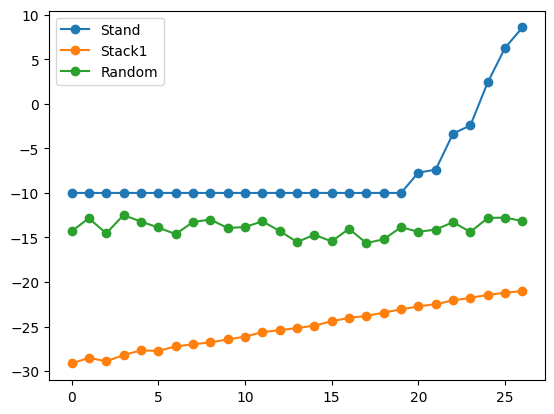

In [9]:
plt.figure()

n = 1000
sj = StackJack()

for policy, name in zip(policies, policyNames):
    values = monteCarloEvalES(sj, policy, n)
    plt.plot(values[0:sj.BUST], 'o-', label = name)

plt.legend()
plt.show()


Obersvations:
- Still looks good for Stack1
- Still looks ok for Random, states seem to have similar variance now
- Works for Stand
- But exploring starts are kind of cheating

## 3. Monte-Carlo control with exploring starts

By learning the action value function and the corresponding greedy policy,
we can find an optimal policy.

In [10]:
# Play one game according to policy
# (Starting in state s0, with action a0)
# (Being able to choose the starting state is kind of cheating!)
def playOneGameES2(sj: StackJack, policy, s0=0, a0=None):
    sj.reset(s0)
    states = [sj.state]
    if a0 is None:
        a0 = sampleAction(policy, sj.state)
    actions = [a0]
    rewards = [0]
    action = a0
    while sj.state != sj.BUST:
        reward, state = sj.step(action)
        action = sampleAction(policy, sj.state)
        rewards.append(reward)
        states.append(sj.state)
        actions.append(action)
        
    return states, actions, rewards

In [11]:
def monteCarloImprove(sj: StackJack, n):
    policy = [[0, 1, 0] for s in sj.STATES]
    qValues = defaultdict(lambda: 0)
    returns = defaultdict(lambda: [])
    
    for i in range(n):
        s0 = np.random.choice(sj.BUST)
        a0 = np.random.choice(N_ACTIONS)
        
        states, actions, rewards = playOneGameES2(sj, policy, s0, a0)
        stateActions = list(zip(states, actions))
        G = 0
        T = len(rewards) - 1
        for t in reversed(range(T)):
            G = GAMMA * G + rewards[t + 1]
            if t>0 and stateActions[t] in stateActions[0:t-1]:
                continue
            returns[states[t], actions[t]].append(G)
            qValues[states[t], actions[t]] = np.mean(returns[states[t], actions[t]])
            actionValues = [qValues[states[t], a] for a in range(N_ACTIONS)]
            bestAction = np.argmax(actionValues)
            policy[states[t]] = [0] * N_ACTIONS
            policy[states[t]][bestAction] = 1
    
    return policy, qValues

Results:

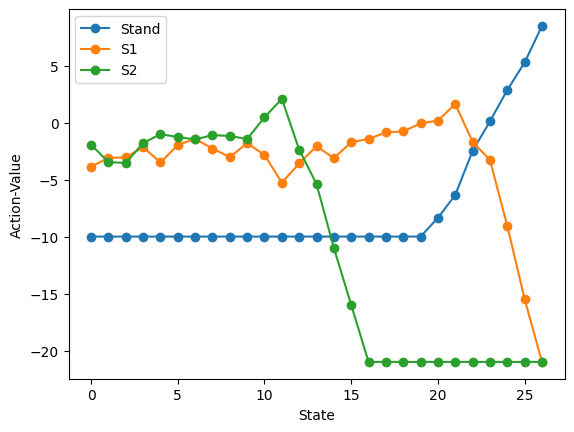

In [12]:
sj = StackJack()
policyAct, qValues = monteCarloImprove(sj, 10000)
actionValueFunction = []
for state in StackJack.STATES:
    actionValues = [qValues[state, action] for action in range(N_ACTIONS)]
    actionValueFunction.append(actionValues)

plt.plot(actionValueFunction[0:sj.BUST], 'o-')
plt.legend(labels = actionNames)
plt.xlabel('State')
plt.ylabel('Action-Value')
plt.show()

Observation:
- Looks kind of ok
- Exploring starts are still cheating!

## 4. Epsilon-greedy Monte-Carlo (on-policy)

By making the policy epsilon-greedy, we do not need exploring starts.

In [13]:
def monteCarloImproveEps(sj: StackJack, n, epsilon=0.1):
    policy = [[1/3, 1/3, 1/3] for s in sj.STATES]
    
    qValues = defaultdict(lambda: 0)
    # Cf. incremental mean:
    hitCounts = defaultdict(lambda: 0)
    
    for i in range(n):
        states, actions, rewards = playOneGame(sj, policy)
        stateActions = list(zip(states, actions))
        G = 0
        T = len(rewards) - 1
        for t in reversed(range(T)):
            G = GAMMA * G + rewards[t + 1]
            if t>0 and stateActions[t] in stateActions[0:t-1]:
                continue
            # Cf. incremental mean:
            hitCounts[states[t], actions[t]] += 1
            qValues[states[t], actions[t]] += 1/hitCounts[states[t], actions[t]] * (G - qValues[states[t], actions[t]])
            actionValues = [qValues[states[t], a] for a in range(N_ACTIONS)]
            bestAction = np.argmax(actionValues)
            policy[states[t]] = [epsilon/N_ACTIONS] * N_ACTIONS
            policy[states[t]][bestAction] += 1 - epsilon
    
    return policy, qValues

Results:

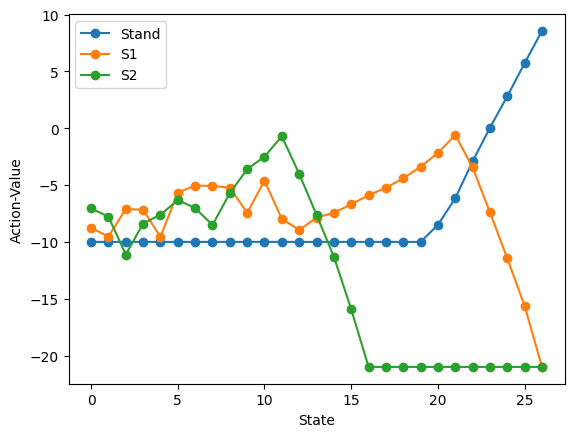

In [14]:
sj = StackJack()
policyAct, qValues = monteCarloImproveEps(sj, 100000, 0.2)
actionValueFunction = []
for state in StackJack.STATES:
    actionValues = [qValues[state, action] for action in range(N_ACTIONS)]
    actionValueFunction.append(actionValues)

plt.plot(actionValueFunction[0:sj.BUST], 'o-')
plt.legend(labels = actionNames)
plt.xlabel('State')
plt.ylabel('Action-Value')
plt.show()

Observations:
- Looks ok
- High variance
- Does not need to cheat!
- However: learns a suboptimal policy (epsilon-soft)

## 5. Epsilon-greedy Monte-Carlo (off-policy)

By only learning from actions, which were followed by optimal behaviour (according to the current action value function),
we learn the optimal greedy policy, while behaving in an epsilon-greedy way:
we learn "off-policy".

In [15]:
def monteCarloImproveEpsOff(sj: StackJack, n, epsilon=0.1):
    policyAct = [[1/3, 1/3, 1/3] for s in sj.STATES]
    policyLearn = [[1/3, 1/3, 1/3] for s in sj.STATES]
    
    qValues = defaultdict(lambda: 0)
    # Cf. incremental mean:
    hitCounts = defaultdict(lambda: 0)
    
    for i in range(n):
        states, actions, rewards = playOneGame(sj, policyAct)
        stateActions = list(zip(states, actions))
        G = 0
        T = len(rewards) - 1
        W = 1
        for t in reversed(range(T)):
            G = GAMMA * G + rewards[t + 1]
            if t>0 and stateActions[t] in stateActions[0:t-1]:
                continue
            # Cf. incremental mean:
            hitCounts[states[t], actions[t]] += W
            qValues[states[t], actions[t]] += 1/hitCounts[states[t], actions[t]] * (G - qValues[states[t], actions[t]])
            actionValues = [qValues[states[t], a] for a in range(N_ACTIONS)]
            bestAction = np.argmax(actionValues)
            policyAct[states[t]] = [epsilon/N_ACTIONS] * N_ACTIONS
            policyAct[states[t]][bestAction] += 1 - epsilon
            policyLearn[states[t]] = [0] * N_ACTIONS
            policyLearn[states[t]][actions[t]] = 1
            if bestAction != actions[t]:
                break
            W *= 1/(policyAct[states[t]][actions[t]])
    
    return policyAct, policyLearn, qValues

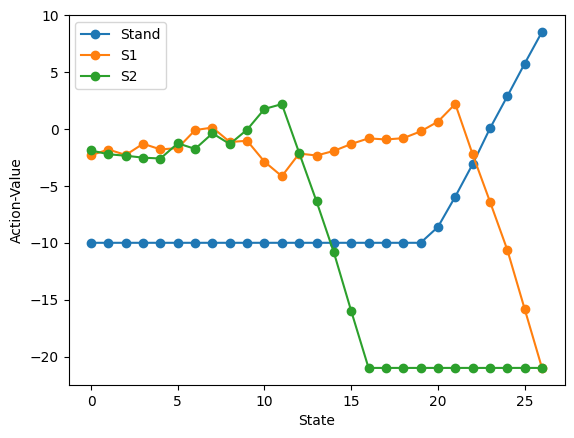

In [16]:
sj = StackJack()
policyAct, policyLearn, qValues = monteCarloImproveEpsOff(sj, 100000, 0.2)
actionValueFunction = []
for state in StackJack.STATES:
    actionValues = [qValues[state, action] for action in range(N_ACTIONS)]
    actionValueFunction.append(actionValues)

plt.plot(actionValueFunction[0:sj.BUST], 'o-')
plt.legend(labels = actionNames)
plt.xlabel('State')
plt.ylabel('Action-Value')
plt.show()